# 04. Классификация

Содержание:
- Методы классификации: Логистическая регрессия
- Методы классификации: Catboost
- Методы классификации: Нейронные сети
- Заключение
- Ссылки для дальнейшего изучения

# 1. Методы классификации: Логистическая регрессия

Несмотря на название, это _линейный классификатор_, а не регрессор. Он предсказывает _вероятность_ того, что объект принадлежит к определенному классу. Для этого используется _сигмоидная функция_ (логистическая функция), которая "сжимает" линейную комбинацию признаков в число от 0 до 1.

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

> Многомерный случай:
> 
> $$\sigma(\mathbf{W}\mathbf{x} + \mathbf{b}) = \frac{1}{1 + e^{-(\mathbf{W}\mathbf{x} + \mathbf{b})}}$$

Алгоритм строит линейную границу принятия решений. Если предсказанная вероятность больше или равна 0.5, объект относится к классу 1, иначе $-$ к классу 0.

![](https://images.spiceworks.com/wp-content/uploads/2022/04/11040521/46-4-e1715636469361.png)


Плюсы:
- Быстрая, понятная

Минусы:
- Плоха на сложных нелинейных зависимостях (если не добавить признаки)

### Почему именно сигмоида?

Логистическая регрессия по своей основе $-$ это линейная модель. В общем многомерном случае она сначала вычисляет линейную комбинацию входных признаков:

$$z = w_1x_1 + w_2x_2 + \ldots + w_nx_n + b$$

где $w$ $-$ веса, $b$ $-$ смещение, $x$ $-$ признаки.

Проблема в том, что результат $z$ может быть любым числом от $-\infty$ до $\infty$.
Нам же для бинарной классификации нужна вероятность того, что объект принадлежит определённому классу, т.е. число от $0$ до $1$.
Это обеспечивает функция $\sigma$.

Кроме этого, использование сигмоиды $-$ следствие из предположения о распределении целевой переменной и принципа _максимального правдоподобия_ (сигмоида максимизирует правдоподобие для бинарных исходов, подчиняющихся распределению Бернулли).

## Пример

Допустим, мы хотим предсказать, купит ли клиент товар, на основе его возраста и времени, проведенного на сайте.

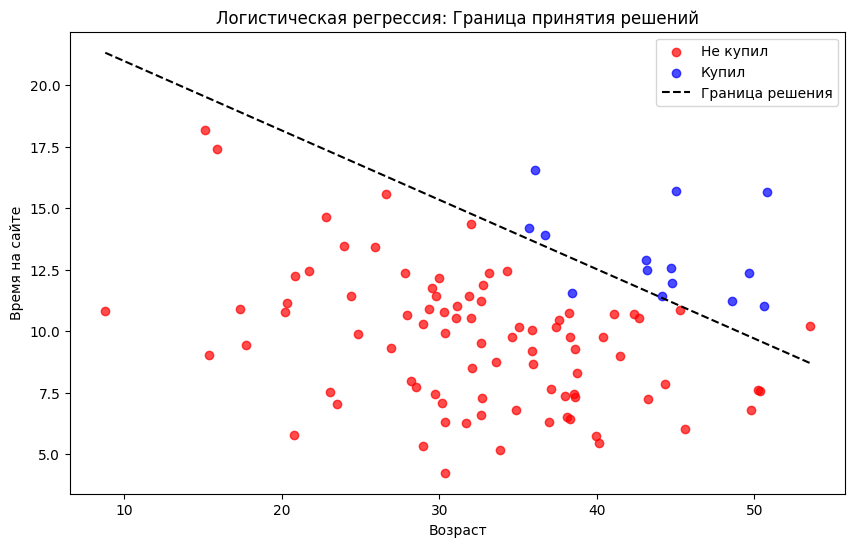

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Сгенерируем синтетические данные
np.random.seed(42)
age = np.random.normal(35, 10, 100) # Возраст
time_on_site = np.random.normal(10, 3, 100) # Время на сайте

# Создаем целевую переменную: 1 если покупка была, 0 если нет
# (логика: вероятность покупки выше у старших и тех, кто дольше на сайте)
purchase = ((age > 40) & (time_on_site > 12) | (age > 35) & (time_on_site > 11)).astype(int)

# Обучаем модель
X = np.column_stack((age, time_on_site))
model = LogisticRegression()
model.fit(X, purchase)

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(age[purchase==0], time_on_site[purchase==0], c='red' , label='Не купил', alpha=0.7)
plt.scatter(age[purchase==1], time_on_site[purchase==1], c='blue', label='Купил', alpha=0.7)

# Строим границу решения
coef = model.coef_[0]
intercept = model.intercept_

age_range = np.linspace(age.min(), age.max(), 100)
decision_boundary = -(coef[0] * age_range + intercept) / coef[1] # Решаем уравнение w*x + b = 0

plt.plot(age_range, decision_boundary, 'k--', label='Граница решения')
plt.xlabel('Возраст')
plt.ylabel('Время на сайте')
plt.legend()
plt.title('Логистическая регрессия: Граница принятия решений')
plt.show()

## Ещё пример

Сначала применим логистическую регрессию, а потом деревья решений, и посмотрим, чем отличается разделение (границы классов).

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [3]:
# Вспомогательные функции для визуализации и оценки

import numpy as np

def plot_decision_boundary(ax, model, X, y, title=""):
    # Сетка точек по двум признакам
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Фон — предсказанные классы
    ax.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.Set3)

    # Точки
    scatter = ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set1, edgecolor='k', s=35)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

def print_binary_metrics(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name}: accuracy={acc:.3f}, precision={prec:.3f}, recall={rec:.3f}, f1={f1:.3f}")

#### Логистическая регрессия

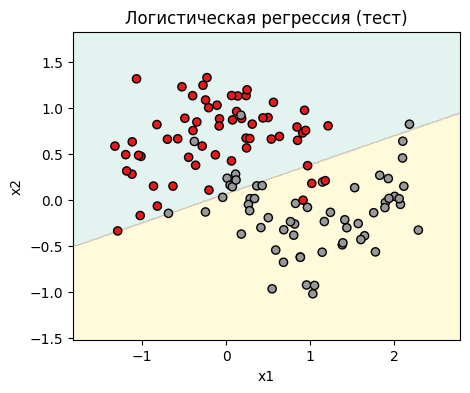

Логистическая регрессия: accuracy=0.900, precision=0.944, recall=0.850, f1=0.895


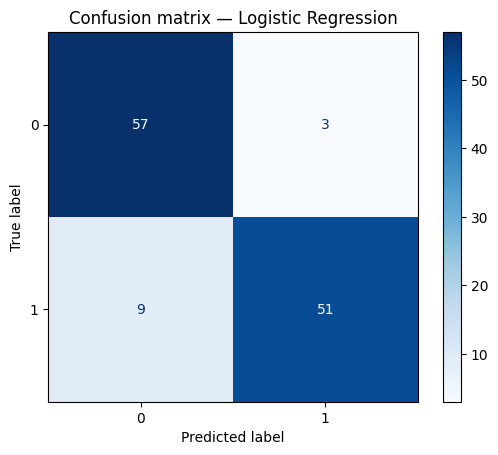

In [4]:
# Данные в виде двух полумесяцев (две луны): нелинейно разделимы
X, y = make_moons(n_samples=400, noise=0.25, random_state=42)

# Разделим на обучение/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Пайплайн: масштабирование + логистическая регрессия
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42))
])
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Визуализация и метрики
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_decision_boundary(ax, logreg, X_test, y_test, title="Логистическая регрессия (тест)")
plt.show()

print_binary_metrics(y_test, y_pred_lr, name="Логистическая регрессия")

# Матрица ошибок
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, cmap="Blues")
plt.title("Confusion matrix — Logistic Regression")
plt.show()

#### Деревья решений

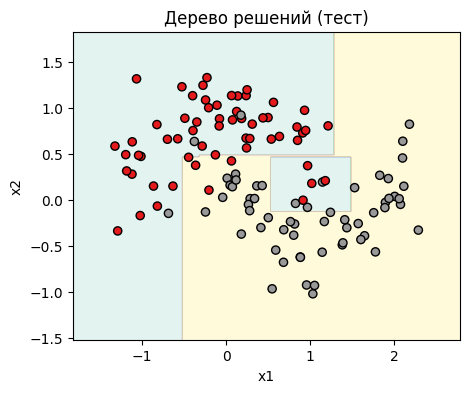

Дерево решений: accuracy=0.925, precision=0.947, recall=0.900, f1=0.923


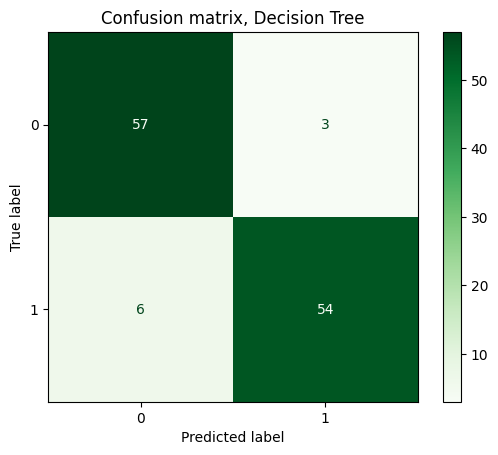

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_decision_boundary(ax, tree, X_test, y_test, title="Дерево решений (тест)")
plt.show()

print_binary_metrics(y_test, y_pred_tree, name="Дерево решений")

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap="Greens")
plt.title("Confusion matrix, Decision Tree")
plt.show()

# 2. Методы классификации: Catboost

CatBoost $-$ это мощный алгоритм, основанный на _градиентном бустинге_ (обучение ансамбля деревьев, где каждое следующее дерево исправляет ошибки предыдущих).
Его ключевая особенность $-$ он отлично работает с категориальными признаками без их предварительной обработки (например, не нужно переводить текстовые метки в числа с помощью [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)).


CatBoost строит множество деревьев последовательно. На каждом шаге он строит новое дерево, которое предсказывает не итоговый ответ, а ошибку предыдущего ансамбля. Так модель постепенно учится исправлять свои недочеты.

Идея:
- Ансамбль многих деревьев, каждое дерево исправляет ошибки предыдущих.
- Отлично работает "из коробки"; хорошо справляется с категориальными признаками (кодирование внутри).

Плюсы:
- Высокое качество, мало ручной подготовки признаков.

Минусы:
- Более тяжелый по времени/ресурсам, больше параметров для настройки.

## Пример

Допустим, у нас есть данные о книгах:
- _жанр_ (категориальный признак),
- _количество страниц_ (числовой признак) и
- _рейтинг_ (целевая переменная: "Низкий", "Средний", "Высокий").

In [6]:
import pandas as pd
from catboost import CatBoostClassifier, Pool

# Данные
data = {
    'Жанр': ['Фэнтези', 'Детектив', 'Наука', 'Фэнтези', 'Детектив'], # Категориальный признак
    'Страницы': [450, 300, 600, 200, 400] # Числовой признак
}
df = pd.DataFrame(data)

# Целевая переменная (мультикласс)
target = ['Высокий', 'Средний', 'Высокий', 'Низкий', 'Средний']

# Создаем объект Pool, явно указывая категориальные признаки
train_pool = Pool(data=df, label=target, cat_features=['Жанр']) # 'Жанр' - категориальный!

# Обучаем модель CatBoost
model = CatBoostClassifier(iterations=100, verbose=False)
model.fit(train_pool)

# Предсказание для новой книги
new_book = pd.DataFrame({'Жанр': ['Наука'], 'Страницы': [550]})
prediction = model.predict(new_book)
pred_proba = model.predict_proba(new_book)

print(f"Предсказанный рейтинг: {prediction[0]}")
print(f"Вероятности: {pred_proba}")

Предсказанный рейтинг: ['Высокий']
Вероятности: [[0.93856712 0.03008372 0.03134916]]


## Ещё пример на данных из предыдущего раздела

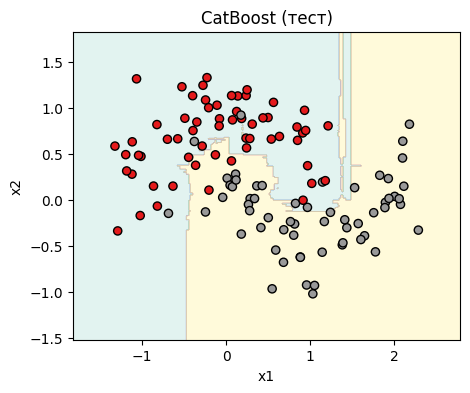

CatBoost: accuracy=0.917, precision=0.931, recall=0.900, f1=0.915


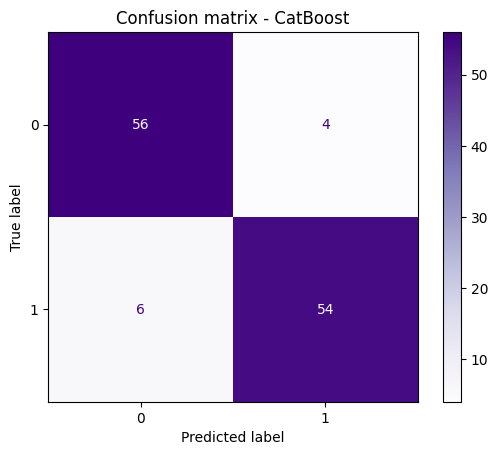

In [7]:
cat = CatBoostClassifier(
    iterations=300,       # число деревьев
    depth=6,              # глубина деревьев
    learning_rate=0.1,    # скорость обучения
    random_state=42,
    verbose=False
)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test).astype(int).ravel()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_decision_boundary(ax, cat, X_test, y_test, title="CatBoost (тест)")
plt.show()

print_binary_metrics(y_test, y_pred_cat, name="CatBoost")

ConfusionMatrixDisplay.from_estimator(cat, X_test, y_test, cmap="Purples")
plt.title("Confusion matrix - CatBoost")
plt.show()

## Мультиклассовая классификация

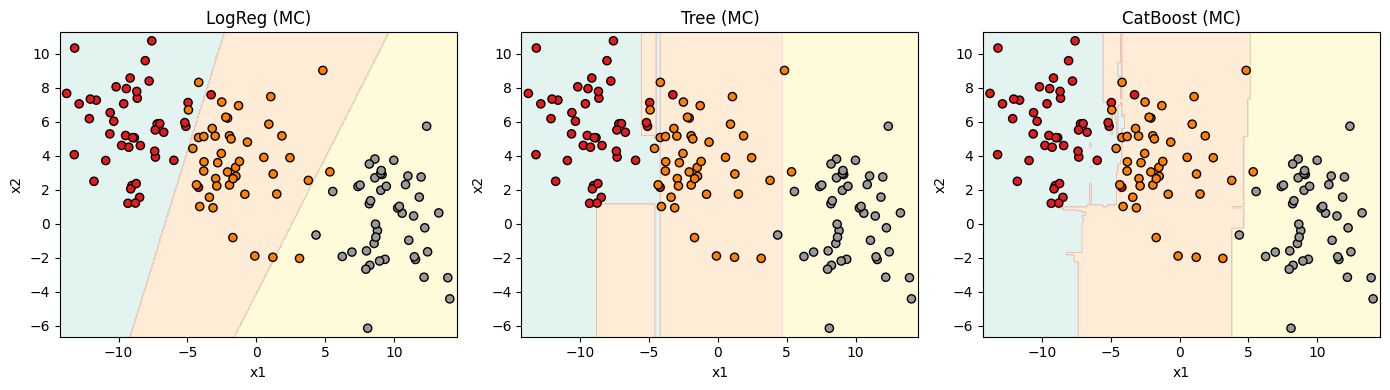

LogReg (MC): accuracy=0.956, macro-F1=0.955
Tree (MC): accuracy=0.926, macro-F1=0.926
CatBoost (MC): accuracy=0.963, macro-F1=0.963


In [8]:
from sklearn.metrics import f1_score
from sklearn.datasets import make_blobs


X3, y3 = make_blobs(n_samples=450, centers=3, cluster_std=2.3, random_state=7)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42, stratify=y3)

# 1) Логистическая регрессия (мультикласс)
logreg_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(solver='lbfgs', random_state=42)) # multi_class='multinomial'
])
logreg_mc.fit(X3_train, y3_train)

# 2) Дерево решений
tree_mc = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_mc.fit(X3_train, y3_train)

# 3) CatBoost (мультикласс)
cat_mc = CatBoostClassifier(
    iterations=300, depth=6, learning_rate=0.1,
    loss_function='MultiClass',
    random_state=42, verbose=False
)
cat_mc.fit(X3_train, y3_train)

models = [("LogReg (MC)", logreg_mc), ("Tree (MC)", tree_mc), ("CatBoost (MC)", cat_mc)]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (name, model) in zip(axes, models):
    plot_decision_boundary(ax, model, X3_test, y3_test, title=name)
plt.tight_layout()
plt.show()

for name, model in models:
    y_pred = model.predict(X3_test)
    acc = accuracy_score(y3_test, y_pred)
    f1m = f1_score(y3_test, y_pred, average='macro')
    print(f"{name}: accuracy={acc:.3f}, macro-F1={f1m:.3f}")

Наблюдения:
- Логистическая регрессия проводит примерно линейные границы между классами.
- Дерево решений даёт "ступенчатые" границы.
- CatBoost чаще даёт более гладкую и качественную границу.

# 3. Методы классификации: Нейронные сети

Нейронная сеть $-$ это математическая модель, вдохновленная работой человеческого мозга.
Она состоит из взаимосвязанных _нейронов_, организованных в _слои_.

![](https://clevertap.com/wp-content/uploads/2019/04/Neural_Network_Brain_Mimic.jpeg)

Основные компоненты:
- _Входной слой (input)_ $-$ получает данные
- _Скрытые слои (hidden)_ $-$ выполняют вычисления
- _Выходной слой (output)_ $-$ выдает результат
- _Веса (weights)_ $-$ параметры, которые обучаются
- _Функции активации (activation functions)_ $-$ добавляют нелинейность

[Источник: [hvidberrrg.github.io](https://hvidberrrg.github.io/deep_learning/activation_functions_in_artificial_neural_networks.html)]

Биологический нейрон:

![](https://hvidberrrg.github.io/deep_learning/assets/sem_image_of_biological_neuron.png)

Математический нейрон:

![](https://hvidberrrg.github.io/deep_learning/assets/activation_function_diagram.png)

## Реализация

Библиотека [PyTorch](https://pytorch.org/) является стандартным инструментом для работы с нейронными сетями. Данные представляются _тензорами_ (многомерными массивами данных).

![](https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png?20211003060202)

## Пример (датасет Iris)

In [9]:
# Импорт библиотек
from sklearn.datasets import load_iris
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#import matplotlib.pyplot as plt
#import numpy as np

# Загрузка данных
iris = load_iris()
X = iris.data[:, :2]  # ВАЖНО! Далее используем только два признака (проще визуализировать)
y = iris.target

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Конвертация в тензоры PyTorch

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

При конструировании нейронной сети нам потребуется:
- линейный слой (Linear)
- нелинейная функция активации (ReLU)
- и функция softmax

_Линейный слой_ преобразует входные данные через умножение на матрицу весов и добавление смещения. Если на входе 100 чисел, а на выходе нужно 10 $-$ линейный слой создаст 10 новых значений, каждое как взвешенную сумму всех входных.

```python
# Из 100 признаков получаем 10
layer = nn.Linear(100, 10)
```

_ReLU_ $-$ функция активации, которая оставляет положительные числа без изменений, а отрицательные заменяет нулями. Нужна, чтобы нейросеть могла решать сложные нелинейные задачи.

```
f(x) = max(0, x)
```

_Softmax_ преобразует любые числа в вероятности. Самые большие числа становятся самыми вероятными, сумма всех выходов всегда равна 1. Используется в последнем слое для классификации.

In [11]:
# Определение нейронной сети

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(2, 10)
        self.output = nn.Linear(10, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.softmax(self.output(x))
        return x

model = SimpleNN()

### Визуализируем построенную модель разными способами

#### Слои и веса

In [12]:
from torchsummary import summary

# Показывает детальную информацию о модели
summary(model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 3]              33
           Softmax-4                    [-1, 3]               0
Total params: 63
Trainable params: 63
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


#### Граф вычислений

_Граф вычислений_ $-$ это способ представить любой математический расчет не как одну гигантскую формулу, а как схему (граф), где:
- Узлы (вершины) $-$ это математические операции (сложение, умножение, синус и т.д.) или входные данные.
- Рёбра (стрелки) $-$ это данные, которые передаются от одной операции к другой.

Граф показывает порядок и зависимость вычислений.

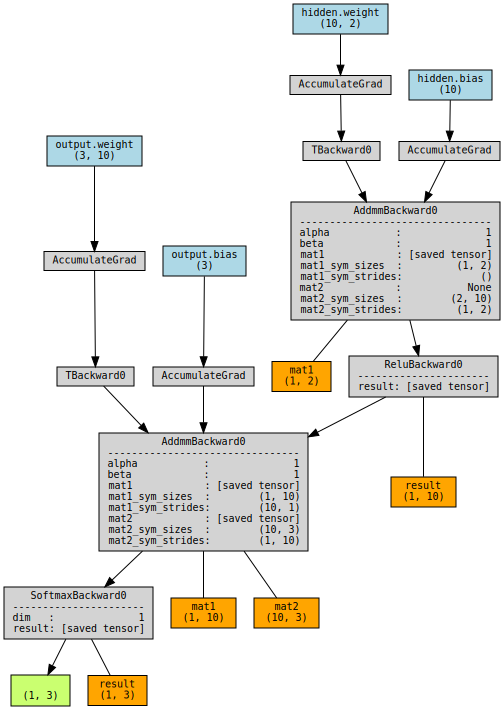

In [13]:
from torchviz import make_dot

x_example = torch.randn(1, 2)  # пример входных данных

# Визуализация графа вычислений
y_pred = model(x_example)
dot = make_dot(y_pred, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
#dot.render('model_architecture', format='png', cleanup=True)
dot

### Обучение нейронной сети

Здесь используются:

- `CrossEntropyLoss()`: функция, которая измеряет, насколько предсказания нейросети отличаются от правильных ответов. Чем больше уверенность в неверном ответе, тем больше штраф. Именно эту величину мы минимизируем при обучении.
- `optim.Adam()`: алгоритм обновления весов нейросети. Смотрит на градиенты (направления, куда нужно изменить веса) и обновляет их с учётом предыдущих изменений.
- `epochs`: количество полных проходов через все обучающие данные. Одна эпоха $-$ когда нейросеть увидела каждый пример из тренировочного набора ровно один раз.
- `losses`: значения функции потерь во время обучения. Мы смотрим на динамику losses, чтобы понять: учится ли модель (loss уменьшается), не переобучилась ли (train loss падает, а val loss растёт).

In [14]:
# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
epochs = 1000
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.100448727607727
Epoch 100, Loss: 0.835780918598175
Epoch 200, Loss: 0.7914052605628967
Epoch 300, Loss: 0.7580726146697998
Epoch 400, Loss: 0.7489451766014099
Epoch 500, Loss: 0.7454941272735596
Epoch 600, Loss: 0.7436076402664185
Epoch 700, Loss: 0.7423549294471741
Epoch 800, Loss: 0.7413936853408813
Epoch 900, Loss: 0.7403637170791626


#### График функции потерь

Text(0, 0.5, 'Loss')

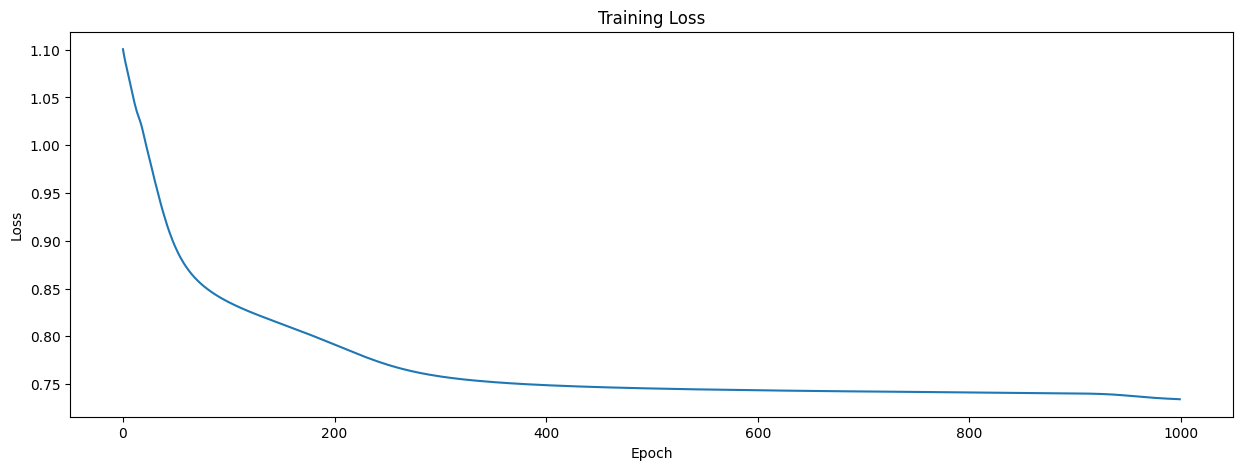

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Проверим работу модели на тестовых данных

Сейчас модель находится в режиме обучения. Чтобы проверить модель на тестовых данных выключим режим обучения.
- `model.eval()`: отключает слои, которые работают только во время обучения (например, `dropout` $-$ который случайно "выключает" часть нейронов для улучшения обобщения)
- `with torch.no_grad()`: контекст, в котором PyTorch не отслеживает операции для вычисления градиентов. Экономит память и ускоряет работу, когда нам нужно только получить предсказания, а не обучать модель

In [16]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'\nTest Accuracy: {accuracy:.4f}')


Test Accuracy: 0.8000


<Figure size 600x500 with 0 Axes>

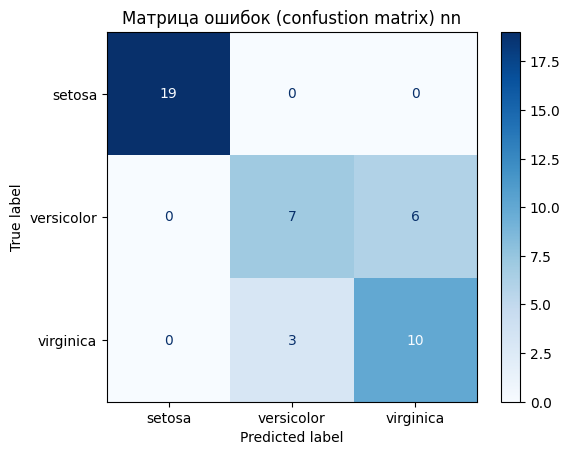

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues')
plt.title('Матрица ошибок (confustion matrix) nn')
plt.show()

In [18]:
from sklearn.metrics import classification_report

print('\nClassification Report:')
print(classification_report(y_test, predicted))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.70      0.54      0.61        13
           2       0.62      0.77      0.69        13

    accuracy                           0.80        45
   macro avg       0.78      0.77      0.77        45
weighted avg       0.81      0.80      0.80        45



### Границы принятия решений

<function matplotlib.pyplot.show(close=None, block=None)>

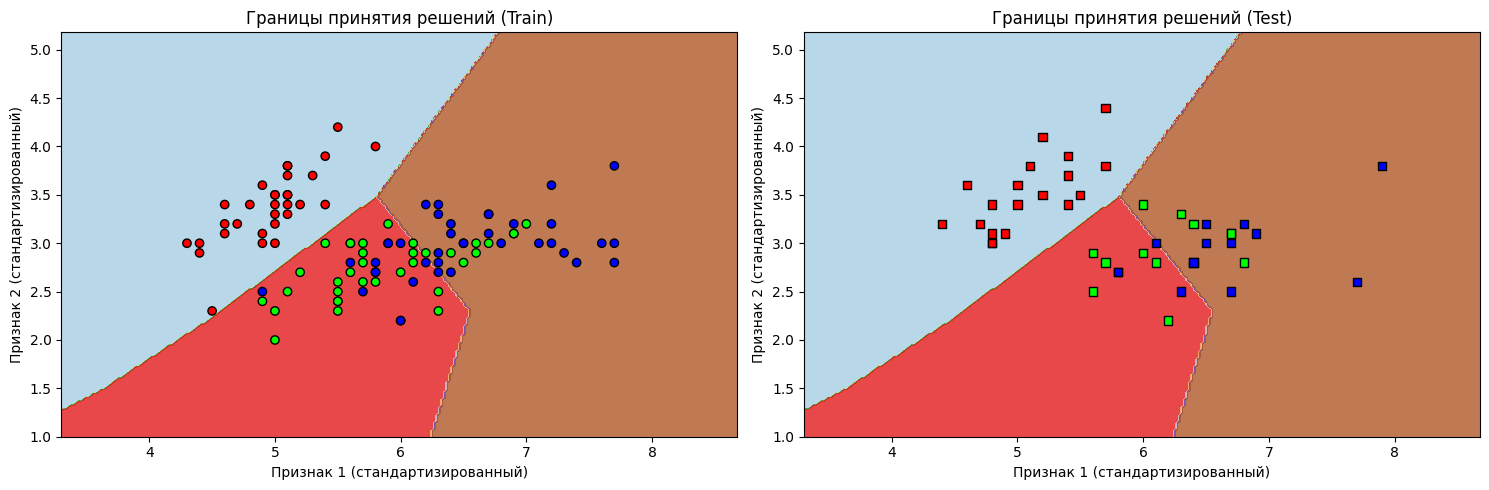

In [19]:
from matplotlib.colors import ListedColormap

# Создаем цветовую карту для классов
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


plt.figure(figsize=(15, 5))

# График границ принятия решений
plt.subplot(1, 2, 1)
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

mesh_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    mesh_outputs = model(mesh_tensor)
    mesh_predicted = torch.max(mesh_outputs, 1)[1]
    Z = mesh_predicted.numpy().reshape(xx.shape)

# Данные обучающей выборки
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=cmap_bold)
plt.xlabel('Признак 1 (стандартизированный)')
plt.ylabel('Признак 2 (стандартизированный)')
plt.title('Границы принятия решений (Train)')

# Тестовые данные
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=cmap_bold, marker='s')
plt.xlabel('Признак 1 (стандартизированный)')
plt.ylabel('Признак 2 (стандартизированный)')
plt.title('Границы принятия решений (Test)')

plt.tight_layout()
plt.show

# Заключение

- Нужна простая, быстрая и базовая модель $-$ логистическая регрессия.
- Нужна интерпретируемость и нелинейность $-$ дерево решений.
- Нужна высокая точность "из коробки" и возможность применять к категориальным признакам $-$ CatBoost.
- Есть много размеченных данных, и задача сложная $-$ нейронные сети.
- Данные не имеют явной структуры, или объекты характеризуются "близостью" (рекомендации, геоданные) $-$ k-ближайших соседей (kNN).

Сравнительная таблица моделей

| Критерий | Логистическая регрессия | Дерево решений | CatBoost | kNN | Нейронные сети |
|----------|--------------------------|----------------|--------------------------|-----|----------------|
| Сложность | Простая | Средняя | Средняя / Сложная | Простая | Сложная |
| Требования к данным | Нет особых требований | Нет особых требований | Желательно много данных | Нет особых требований | Много данных |
| Интерпретируемость | Высокая | Высокая | Средняя | Высокая | Низкая |
| Время обучения | Быстрое | Быстрое | Среднее / Длительное | Не требует обучения | Длительное |
| Время предсказания | Быстрое | Быстрое | Быстрое | Медленное | Быстрое |
| Устойчивость к шуму | Средняя | Низкая | Высокая | Низкая | Средняя / Высокая |

Не забывайте:

1. Разделять данные на train/test
2. Следить за дисбалансом классов
3. Настраивать параметры методов (гиперпараметры)
4. Масштабировать признаки для kNN, логистической регрессии и нейронных сетей.

# Ссылки для дальнейшего изучения

- PyTorch (официальный туториал): https://pytorch.org/
- CatBoost (официальная документация): https://catboost.ai/
- Boosting (обзор): https://xgboost.readthedocs.io/en/stable/tutorials/model.html (для общего понимания бустинга)
- Визуализация методов классификации: https://ml-playground.com/